In [31]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle
import copy
import cv2
import math
from matplotlib import animation, rc
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
from opmap.RawCam import RawCam
from opmap.VmemMap import VmemMap
from opmap.PhaseMap import PhaseMap
from opmap.PhaseVarianceMap import PhaseVarianceMap
from opmap.PhaseVariancePeakMap import PhaseVariancePeakMap
from opmap.util import makeMovie

In [41]:
exp_dir = "/mnt/recordings/ExperimentData/"
anl_dir = "/mnt/recordings/AnalysisResult/Tomii/2017-07-25/"

df_path = os.path.join( anl_dir, "control_s1s2.csv" )

delay = 5

pv_thre = 0.7

In [42]:
def show_session(s):
    for key in s.keys(): 
        print "{0}:{1}".format(key, s[key])
    
#def integrate_all(cam, vmem, pmap, pvmap, stim_x, stim_y ):
def integrate_all(cam, vmem, pmap, pvmap):
    
    shape = pvmap.data.shape
    phase_wf = -1.9
    phase_wt = 2.3
    phase_w = 0.075
    step = vmem.data.shape[1] /  pvmap.data.shape[1] 
    
    rgb_img = np.zeros( (shape[0]-delay, shape[1], shape[2], 3), dtype=np.uint8)
    
    #------------------
    # Camera
    #------------------
    rgb_img[:,:,:,1] = (  (cam.data[delay:,::step,::step] - cam.vmin) / (cam.vmax-cam.vmin)*96 ).astype(np.uint8)
    
    #------------------
    # Vmem
    #------------------
    # rgb_img[:,:,:,0] = ( (vmem.data[delay:,::step,::step]-vmem.vmin)*0.5*255 ).astype(np.uint8)
    rgb_img[:,:,:,2] = 127 + ( vmem.data[delay:,::step,::step]*128 ).astype(np.uint8)
    rgb_img[:,:,:,0] = 127 + ( - vmem.data[delay:,::step,::step]*128 ).astype(np.uint8)
    
    #------------------
    # WF
    #------------------
    mask = (( np.abs( pmap.data - phase_wf ) < phase_w )*1.0).astype(np.uint8)[:-delay,:,:]
    for i in range(3) : rgb_img[:,:,:,i] *= (1-mask)
    rgb_img[:,:,:,2] += mask*255

    #------------------
    # WT
    #------------------
    mask = (( np.abs( pmap.data - phase_wt ) < phase_w )*1.0).astype(np.uint8)[:-delay,:,:]
    for i in range(3) : rgb_img[:,:,:,i] *= (1-mask)
    rgb_img[:,:,:,0] += mask*255
    
    #------------------
    # ROI
    #------------------
    for i in range(shape[0]-delay) : 
        for c in range(3):
            rgb_img[i,:,:,c] *= pvmap.roi[:,:].astype(np.uint8)
        
    #------------------
    # PS (#FFFFFF)
    #------------------
    mask = (( pvmap.data > pv_thre )*1.0).astype(np.uint8)[:-delay,:,:]
    for i in range(3) : rgb_img[:,:,:,i] *= (1-mask)
    for i in range(3) : rgb_img[:,:,:,i] += mask*(255*pvmap.data[:-delay,:,:]).astype(np.uint8)
        
    #------------------
    # Stim point (#FFFF00)
    #------------------
    #mask = np.zeros( (shape[0]-delay, shape[1], shape[2]), dtype=np.uint8 )
    #mask[ :, stim_y-1:stim_y+2, stim_x-1:stim_x+2 ] = 1
    #for i in range(3) : rgb_img[:,:,:,i] *= (1-mask)
    #rgb_img[:,:,:,2] += (mask*255).astype(np.uint8)
    #rgb_img[:,:,:,1] += (mask*255).astype(np.uint8)        
    
    return rgb_img



## Data frameロード

In [54]:
df = pd.read_csv(df_path)
print "N:",len(df)
#df

N: 6


In [55]:

sessions = range(len(df))


In [45]:
for i in sessions:
    
    s = df.loc[i,:]
    
    sample = s["sample"]
    session = s["session"]
    target = "{0}/{1}/C001H001S{2:0>4}".format(exp_dir, sample, session)    
    save_dir = target.replace(exp_dir, anl_dir)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    print "{0}:{1}".format(i, target)
    
    if 'cam' in locals() : del(cam)
    if 'vmem' in locals() : del(vmem)
    if 'pmap' in locals() : del(pmap)
    if 'pvmap' in locals() : del(pvmap)
    if 'pvpmap' in locals() : del(pvpmap)

    cam = RawCam(
        path = target,
        cam_type = 'sa4', 
        image_height = 512, image_width = 512, 
        frame_start = 0, frame_end = 800 )
    vmem = VmemMap( cam )
    vmem_ = copy.deepcopy(vmem)
    vmem_.setDiffRange(diff_min=64)
    vmem_.morphROI(closing=12)
    vmem_.morphROI(erosion=6)
    vmem_.smooth(15)
    pmap = PhaseMap( vmem_ )
    pvmap = PhaseVarianceMap(pmap, size=5)
    pvpmap = PhaseVariancePeakMap(pvmap)
    core_log = pvpmap.getCoreLog()
    #rgb_img = integrate_all(cam, vmem_, pmap, pvmap, stim_x=s["stim_x"], stim_y=s["stim_y"])
    rgb_img = integrate_all(cam, vmem_, pmap, pvmap)
    
    if False:
        np.savez(os.path.join(save_dir, "vmem"), vmem.data)
        np.savez(os.path.join(save_dir, "pmap"), pmap.data)
        np.savez(os.path.join(save_dir, "pvmap"), pvmap.data)
        np.savez(os.path.join(save_dir, "pvpmap"), pvpmap.data)

    with open(os.path.join(save_dir, "center.csv"), 'w') as outf:
        for row in core_log:
            str_line = ''
            for elem in row:
                str_line += '{0},'.format(elem)
            str_line.rstrip(',')
            outf.write(str_line)
            outf.write('\n')
            
    #with open(os.path.join(save_dir, "elec_phase.log"), 'w') as outf:
    #    elec_phase = pmap.data[:, s["stim_y"], s["stim_x"]]
    #   for i, v in enumerate(elec_phase):
    #        outf.write('{0} {1}\n'.format(i, v))

    dirs = []

    #d = os.path.join( save_dir , "vmem");  vmem.saveImage(d); dirs.append(d)
    #d = os.path.join( save_dir , "pmap"); pmap.saveImage(d); dirs.append(d)
    #d = os.path.join( save_dir , "pvmap"); pvmap.saveImage(d); dirs.append(d)
    #d = os.path.join( save_dir , "pvpmap"); pvpmap.saveImage(d); dirs.append(d)

    d = os.path.join( save_dir , "all")
    if not os.path.exists(d) : os.mkdir(d)
    dirs.append(d)
    for i, img in enumerate(rgb_img):
        #im = plt.imshow(img)
        #plt.savefig(os.path.join(d, "{0:0>6}.png".format(i)))
        cv2.putText(img,"{0:0>4}ms".format(i), (4,16), cv2.FONT_HERSHEY_PLAIN, 0.6, (255,255,255))
        cv2.imwrite(os.path.join(d, "{0:0>6}.png".format(i)), img)
        
    for d in dirs: makeMovie(d)


0:/mnt/recordings/ExperimentData//20160907-3/C001H001S0002


KeyboardInterrupt: 

0:/mnt/recordings/AnalysisResult/Tomii/2017-07-25//20160907-3/C001H001S0002
sample     20160907-3
session             2
speed            1575
Name: 0, dtype: object
prop spee:1575
vel_max:0.134038799753


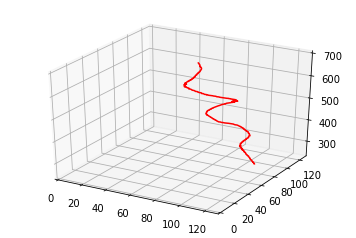

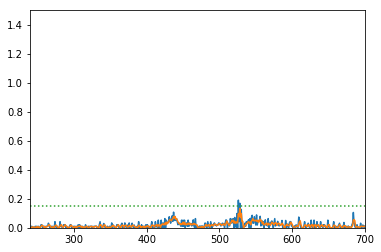

1:/mnt/recordings/AnalysisResult/Tomii/2017-07-25//20161019-1/C001H001S0013
sample     20161019-1
session            13
speed            1214
Name: 1, dtype: object
prop spee:1214
vel_max:0.120812738935


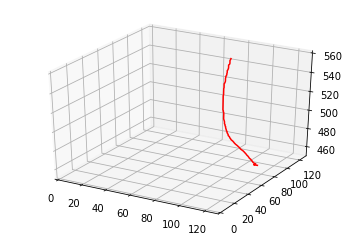

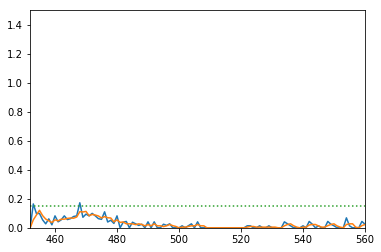

2:/mnt/recordings/AnalysisResult/Tomii/2017-07-25//20161019-2/C001H001S0005
sample     20161019-2
session             5
speed            1500
Name: 2, dtype: object
prop spee:1500
vel_max:0.0800000031789


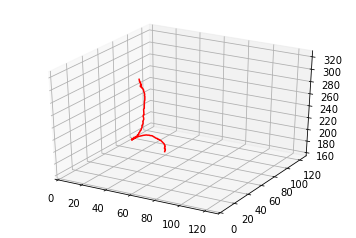

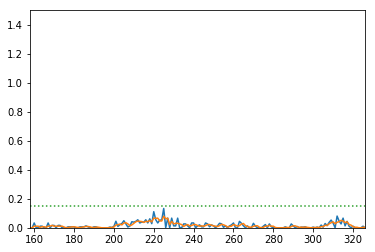

3:/mnt/recordings/AnalysisResult/Tomii/2017-07-25//20161019-3/C001H001S0023
sample     20161019-3
session            23
speed            1252
Name: 3, dtype: object
prop spee:1252
vel_max:0.0532481372356


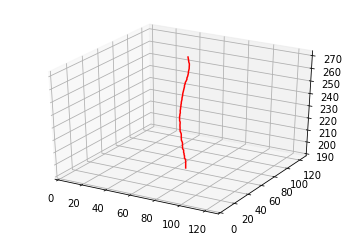

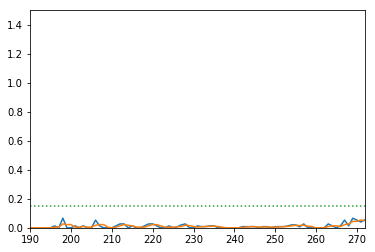

4:/mnt/recordings/AnalysisResult/Tomii/2017-07-25//20161021-1/C001H001S0008
sample     20161021-1
session             8
speed            1633
Name: 4, dtype: object
prop spee:1633
vel_max:0.161442965269


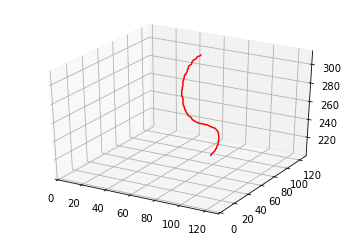

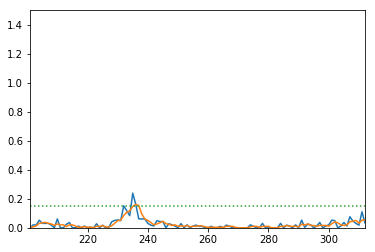

5:/mnt/recordings/AnalysisResult/Tomii/2017-07-25//20161021-2/C001H001S0006
sample     20161021-2
session             6
speed            2529
Name: 5, dtype: object
prop spee:2529
vel_max:0.164755503957


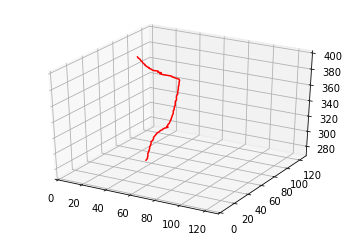

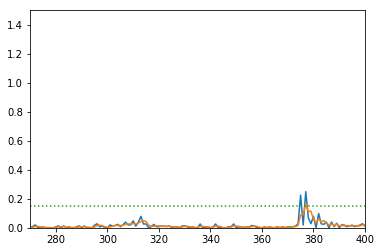

In [80]:
vel_all = np.array([])

for i in sessions:
    
    s = df.loc[i,:]
    sample = s["sample"]
    session = s["session"]
    target = "{0}/{1}/C001H001S{2:0>4}".format(exp_dir, sample, session)    
    save_dir = target.replace(exp_dir, anl_dir)

    print "{0}:{1}".format(i, save_dir)
    print s
    
    file_path = os.path.join(save_dir, 'center_target.csv')
    traj = np.loadtxt(file_path, delimiter=',')
    
    vel = np.zeros((len(traj), 2), dtype=np.float32)
    vel[:,0] = traj[:, 0]
    vel[0,1] = 0.
    for i in range(len(traj)-1): 
        vel[i+1, 1] = np.linalg.norm( np.array(traj[i+1,2] - traj[i,2], traj[i+1,1] - traj[i,1]) ) / float(s["speed"] * 10e-3)
        #vel[i+1, 1] = np.linalg.norm( np.array(traj[i+1,2] - traj[i,2], traj[i+1,1] - traj[i,1]) ) / 1.575
    vel_ave = np.convolve( np.ones(3)/3, vel[:,1])[:-3+1]
    vel_all = np.concatenate((vel_all, vel_ave), axis=0)
    
    print 'prop spee:{0}'.format(s["speed"])
    print 'vel_max:{0}'.format(np.max(vel_ave))
        
    if True:
    
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        ax.plot(traj[:,2], traj[:,1], traj[:,0], color='red')
        
        plt.xlim([0,128])
        plt.ylim([0,128])
        plt.savefig(os.path.join(save_dir, "plot_3d.png"))
        plt.show()
        
    if True:

        plt.clf()
        plt.plot(vel[:,0], vel[:,1])
        plt.plot(vel[:,0],  vel_ave)
        plt.plot( np.array([vel[0,0],vel[-1,0]]), np.array([0.15, 0.15] ), linestyle="dotted" )
        plt.savefig(os.path.join(save_dir, "plot_velocity.png"))
        plt.xlim([vel[0,0],vel[-1,0]])
        plt.ylim([0,1.5])
        plt.show()    

(1065,)


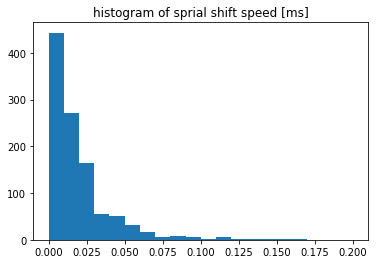

In [79]:
print vel_all.shape
plt.hist(vel_all, np.arange(0,0.21,0.01))
plt.title("histogram of sprial shift speed [ms]")
plt.show()